# Imports

In [1]:
import sys
import os

# Dynamically add the root directory to sys.path
# Assumes that 'models' and 'utils' are in the same project root directory
project_root = os.path.abspath(os.path.join(os.path.dirname('.'), '..'))
sys.path.insert(0, project_root)

In [2]:

import math
from sklearn.metrics import accuracy_score
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torcheeg import transforms
from torch.utils.data import DataLoader
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from torcheeg.datasets.constants import DREAMER_ADJACENCY_MATRIX
from torcheeg.datasets import DREAMERDataset, DEAPDataset
from torcheeg.model_selection import KFoldGroupbyTrial
from torcheeg.model_selection import train_test_split_groupby_trial

from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import r2_score
from torchmetrics import Accuracy
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm
import re
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score



In [4]:
# Local Imports
from utils.checkpoint import train_and_save,  train_validate_and_save, train_validate_test_and_save, tvt_save_acc_loss_f1
from utils.log import get_logger
from utils.utils import print_var, train_one_epoch, train_one_epoch_lstm, get_num_params, train_one_step_tqdm
from utils.transforms import STFTSpectrogram

from models.cnn import Two_Layer_CNN, Two_Layer_CNN_Pro, Simplified_CNN
from models.rnns import LSTM
from models.cnn_lstm import LSTM_CNN_Model
from models.Tsception import TSCEPTIONModel
from models.YoloV9 import YOLO9_Backbone_Classifier
from models.eegnet import EEGNet_Normal_data
from models.Transformer import VanillaTransformer_time
from models.tcn_based import EEGTCNet , TCNet_Fusion , ATCNet
from models.gnn_based import DGCNN

from models.dgcnn_test import DGCNN

# Utils

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Functions

In [6]:
def train_one_step_tqdm_withF1(model, train_loader, loss_fn, optimizer, device, epoch=None, is_binary=True ,num_classes=None):
    model.train()
    loss_train = AverageMeter()
    f1_train = AverageMeter()

    if is_binary:
        acc_train = BinaryAccuracy().to(device)
    else:
        acc_train = Accuracy(task='multiclass', num_classes= num_classes).to(device)
    
    with tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch != None:
                tepoch.set_description(f"Epoch: {epoch}")
            inputs = inputs.to(device)
            targets = targets.to(device)

            # remove nan data 
            inputs = torch.stack([data for data in inputs if ~torch.isnan(data).any()])
            targets = torch.stack([targets[i] for (i,data) in enumerate(inputs) if ~torch.isnan(data).any()])

            if is_binary:
                targets = targets.float()
            else:
                targets = targets.squeeze().long()

            outputs = model(inputs) + 1e-8  
            loss = loss_fn(outputs, targets) + 1e-8 

            predictions = torch.argmax(F.softmax(outputs,dim=1),dim=1).squeeze().detach().cpu()
            f1 = f1_score(targets.cpu(), predictions)

            loss.backward()
            
            # Weight Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5) ## 0.5 NEW ADDITION

            optimizer.step()
            optimizer.zero_grad()
            
            f1_train.update(f1)
            loss_train.update(loss.item())
            acc_train(outputs.squeeze(), targets.int())
            
            tepoch.set_postfix(loss= loss_train.avg,
                                accuracy= 100.0 * acc_train.compute().item(),
                                F1= f1_train.avg)

    return model, loss_train.avg, acc_train.compute().item(), f1_train.avg

In [92]:
def validation_with_tqdm_withF1(model, test_loader, loss_fn, device='cpu', is_binary=True, num_classes=None):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        f1_valid = AverageMeter()
        
        if is_binary:
            acc_valid = BinaryAccuracy().to(device)
        else:
            acc_valid = Accuracy(task='multiclass', num_classes= num_classes).to(device)

    with tqdm(test_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            tepoch.set_description(f"Validation - ")

            inputs = inputs.to(device)
            targets = targets.to(device)

            # remove nan data 
            inputs = torch.stack([data for data in inputs if ~torch.isnan(data).any()])
            targets = torch.stack([targets[i] for (i,data) in enumerate(inputs) if ~torch.isnan(data).any()])

            if is_binary:
                targets = targets.float()
            else:
                targets = targets.squeeze().long()

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            predictions = torch.argmax(F.softmax(outputs,dim=1),dim=1).squeeze().detach().cpu()
            f1 = f1_score(targets.cpu(), predictions)

            f1_valid.update(f1)
            loss_valid.update(loss.item())
            acc_valid(outputs.squeeze(), targets.int())
            tepoch.set_postfix(loss= loss_valid.avg,
                                accuracy= 100.0 * acc_valid.compute().item(),
                                F1= f1_valid.avg)

    return loss_valid.avg, acc_valid.compute().item(), f1_valid.avg

# Get Dataset

In [103]:
try:
    del dataset
except:
    pass

In [104]:
dataset = None
dataset_name = ''
emotion_dim = 'valence'  # valence, dominance, or arousal
# nb == No Baseline Removal
DATA_SET = 'DREAMER_t0' # 'DREAMER_t1' , 'DEAP' , 'DEAP_o32' , 'DREAMER_t1_b' , 'DEAP_t1_b' , 'DEAP_DE', 'DREAMER_t0'

In [105]:
if DATA_SET == 'DREAMER_t1':
    dataset_name= 'Dreamer_time_01'
    
    io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset 
    mat_path= '../raw_data/DREAMER.mat'
    dataset = DREAMERDataset(io_path=f"{io_path}",
                            mat_path=mat_path,
                            offline_transform=transforms.Compose([
                                # normalize along the second dimension (temproal dimension)
                                transforms.MeanStdNormalize(axis=1, apply_to_baseline=True),# MeanStdNormalize() , MinMaxNormalize()
                            ]),
                            online_transform=transforms.Compose([
                                # transforms.BaselineRemoval(),
                                transforms.To2d(apply_to_baseline=True),
                                transforms.ToTensor(),
                            ]),
                            label_transform=transforms.Compose([
                                transforms.Select(emotion_dim),
                                transforms.Binary(threshold=2.5),   
                            ]),
                            chunk_size=128, # -1 would be all the data of each trial for a chunk
                            overlap = 0, 
                            io_mode = 'lmdb',
                            baseline_chunk_size=128,
                            num_baseline=61,
                            num_worker=4)

elif DATA_SET == 'DREAMER_t0':
    dataset_name= 'Dreamer_time_01'
    
    io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset 
    mat_path= '../raw_data/DREAMER.mat'
    dataset = DREAMERDataset(io_path=f"{io_path}",
                            mat_path=mat_path,
                            offline_transform=transforms.Compose([
                                # normalize along the second dimension (temproal dimension)
                                transforms.MeanStdNormalize(axis=1, apply_to_baseline=True),# MeanStdNormalize() , MinMaxNormalize()
                            ]),
                            online_transform=transforms.Compose([
                                # transforms.BaselineRemoval(),
                                # transforms.To2d(apply_to_baseline=True),
                                transforms.ToTensor(),
                            ]),
                            label_transform=transforms.Compose([
                                transforms.Select(emotion_dim),
                                transforms.Binary(threshold=2.5),   
                            ]),
                            chunk_size=128, # -1 would be all the data of each trial for a chunk
                            overlap = 0, 
                            io_mode = 'lmdb',
                            baseline_chunk_size=128,
                            num_baseline=61,
                            num_worker=4)

elif DATA_SET == 'DREAMER_t1_b':
    dataset_name= 'Dreamer_time_01'
    
    io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset 
    mat_path= '../raw_data/DREAMER.mat'
    dataset = DREAMERDataset(io_path=f"{io_path}",
                            mat_path=mat_path,
                            offline_transform=transforms.Compose([
                                # normalize along the second dimension (temproal dimension)
                                transforms.MeanStdNormalize(axis=1, apply_to_baseline=True),# MeanStdNormalize() , MinMaxNormalize()
                            ]),
                            online_transform=transforms.Compose([
                                # transforms.BaselineRemoval(),
                                transforms.To2d(apply_to_baseline=True),
                                transforms.BaselineRemoval(),
                                transforms.ToTensor(),
                            ]),
                            label_transform=transforms.Compose([
                                transforms.Select(emotion_dim),
                                transforms.Binary(threshold=2.5),   
                            ]),
                            chunk_size=128, # -1 would be all the data of each trial for a chunk
                            overlap = 0, 
                            io_mode = 'lmdb',
                            baseline_chunk_size=128,
                            num_baseline=61,
                            num_worker=4)
elif DATA_SET == 'DEAP':
    
    dataset_name = 'DEAP_time_01_no' # Time data which is stored in memory
    root_path = '../raw_data/DEAP'
    io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset
    dataset = DEAPDataset( root_path=root_path,
                            io_path=io_path,
                            offline_transform=transforms.Compose([
                                transforms.MeanStdNormalize(axis=1, apply_to_baseline=True),# MeanStdNormalize() , MinMaxNormalize()
                            ]),
                            online_transform=transforms.Compose([
                                transforms.To2d(apply_to_baseline=True),
                                transforms.ToTensor(),
                            ]),
                            label_transform=transforms.Compose([
                                transforms.Select(emotion_dim),
                                transforms.Binary(5.0),
                            ]),
                            overlap = 0, # 
                            io_mode='lmdb',
                            num_worker=4,
                        )

elif DATA_SET == 'DEAP_t1_b':
    
    dataset_name = 'DEAP_time_01_no' # Time data which is stored in memory
    root_path = '../raw_data/DEAP'
    io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset
    dataset = DEAPDataset( root_path=root_path,
                            io_path=io_path,
                            offline_transform=transforms.Compose([
                                transforms.MeanStdNormalize(axis=1, apply_to_baseline=True),# MeanStdNormalize() , MinMaxNormalize()
                            ]),
                            online_transform=transforms.Compose([
                                transforms.To2d(apply_to_baseline=True),
                                transforms.BaselineRemoval(),
                                transforms.ToTensor(),
                            ]),
                            label_transform=transforms.Compose([
                                transforms.Select(emotion_dim),
                                transforms.Binary(5.0),
                            ]),
                            overlap = 0, # 
                            io_mode='lmdb',
                            num_worker=4,
                        )

elif DATA_SET == "DEAP_o32":
    
    dataset_name = 'DEAP_time_o32_nb' # Time data which is stored in memory
    root_path = '../raw_data/DEAP'
    io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset
    dataset = DEAPDataset( root_path=root_path,
                            io_path=io_path,
                            offline_transform=transforms.Compose([
                                transforms.MeanStdNormalize(axis=1, apply_to_baseline=True),# MeanStdNormalize() , MinMaxNormalize()
                            ]),
                            online_transform=transforms.Compose([
                                transforms.To2d(apply_to_baseline=True),
                                transforms.ToTensor(),
                                ]),
                            label_transform=transforms.Compose([
                                transforms.Select(emotion_dim),
                                transforms.Binary(5.0),
                            ]),
                            overlap = 96, # 128 - 32
                            io_mode='lmdb',
                            num_worker=4,
                        )

elif DATA_SET == "DEAP_DE":
    dataset_name = 'DEAP_DE' # Time data which is stored in memory
    root_path = '../raw_data/DEAP'
    io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset
    dataset = DEAPDataset( root_path=root_path,
                            io_path=io_path,
                            offline_transform=transforms.Compose([
                                transforms.BandDifferentialEntropy(band_dict={"delta": [1, 4],"theta": [4, 8],\
                                                                   "alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}, \
                                                                    apply_to_baseline=True),
                                # transforms.MeanStdNormalize(axis=1, apply_to_baseline=True),# MeanStdNormalize() , MinMaxNormalize()
                            ]),
                            online_transform=transforms.Compose([
                                # transforms.To2d(apply_to_baseline=True),
                                transforms.ToTensor(),
                            ]),
                            label_transform=transforms.Compose([
                                transforms.Select(emotion_dim),
                                transforms.Binary(5.0),
                            ]),
                            overlap = 0, # 
                            io_mode='lmdb',
                            num_worker=4,
                        )

[2025-01-01 17:49:09] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../saves/datasets/Dreamer_time_01.


In [106]:
dataset

DREAMERDataset(
    io_path='../saves/datasets/Dreamer_time_01',
    io_size=1048576,
    io_mode='lmdb',
    mat_path='../raw_data/DREAMER.mat',
    chunk_size=128,
    overlap=0,
    num_channel=14,
    num_baseline=61,
    baseline_chunk_size=128,
    online_transform=Compose(
    ToTensor(apply_to_baseline=False)
),
    offline_transform=Compose(
    MeanStdNormalize(apply_to_baseline=True, mean=None, std=None, axis=1)
),
    label_transform=Compose(
    Select(key='valence'),
    Binary(threshold=2.5)
),
    before_trial=None,
    after_trial=None,
    num_worker=4,
    verbose=True
)
length=85744

In [107]:
dataset[0][0].shape

torch.Size([14, 128])

In [108]:
dataset[0][1]

1

# Train Test Validation Split

In [109]:
# Split train val test 
train_dataset, test_dataset = train_test_split_groupby_trial(dataset= dataset, test_size = 0.2, shuffle= True) #, random_state= rng_num)
train_dataset, val_dataset = train_test_split_groupby_trial(dataset= train_dataset, test_size = 0.1, shuffle=True) #, random_state= rng_num)

[2025-01-01 17:49:16] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-01-01 17:49:16] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg\model_selection_1735741156336_GkDnP for the next run, if you want to use the same setting for the experiment.
[2025-01-01 17:49:18] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-01-01 17:49:18] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg\model_selection_1735741158067_a7nAo for the next run, if you want to use the same setting for the experiment.


# DataLoader

In [110]:
batch_size = 512

In [111]:
# Create train/val/test dataloaders
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

# Check dataset size and so on 

In [112]:
print("Dataset is ready!")
print(f"Dataset size: {len(dataset)}")
print(f"Train Size: {len(train_dataset)}, Validation Size: {len(val_dataset)} , Test Size: {len(test_dataset)}")
print(f"Input data shape: {dataset[0][0].shape}")
print(f"Output data (one sample): {dataset[0][1]}")

print('*' * 30)

print_var("Number of batches inside train dataloader",len(train_loader))
print_var("Number of batches inside validation dataloader",len(val_loader))
print_var("Number of batches inside test dataloader",len(test_loader))

print('*' * 30)

Dataset is ready!
Dataset size: 85744
Train Size: 61364, Validation Size: 7038 , Test Size: 17342
Input data shape: torch.Size([14, 128])
Output data (one sample): 1
******************************
Number of batches inside train dataloader : 120
Number of batches inside validation dataloader : 14
Number of batches inside test dataloader : 34
******************************


# Choose Device

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Choose model

In [114]:
# ****************** Choose your Model ******************************
# model = Two_Layer_CNN()
# model = EEGTCNet(n_classes=2)
# model = TCNet_Fusion(input_size= dataset[0][0].shape, n_classes= 2, channels= dataset[0][0].shape[1], sampling_rate= 128)

# model = ATCNet(dataset[0][0].shape, dataset[0][0].shape[1] , n_classes=2, n_windows=8,
#                    eegn_F1=24, eegn_D=2, eegn_kernelSize=50, eegn_poolSize=1, eegn_dropout=0.3, num_heads=2,
#                    tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, fuse='average',activation='elu')

model = DGCNN(in_channels= 5,
              num_electrodes= 32,
              num_layers= 2,
              hid_channels= 32,
              num_classes= 2)

In [115]:
print(f"Selected model name : {model.__class__.__name__}")
# print(f"Model parameter count: {get_num_params(model,1)}")
print_var("Model is ", model)
print('*' * 30)

Selected model name : DGCNN
Model is  : DGCNN(
  (layer1): Chebynet(
    (gc1): ModuleList(
      (0-1): 2 x GraphConvolution()
    )
  )
  (BN1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(
    (linear): Linear(in_features=1024, out_features=64, bias=True)
  )
  (fc2): Linear(
    (linear): Linear(in_features=64, out_features=2, bias=True)
  )
)
******************************


#  Choose Loss Function

In [116]:
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()


# Choose Optimizer

In [117]:
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0001  0.001
# optimizer = optim.Adam(model.parameters(), lr=0.01) # lr = 0.0001  0.001
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.937)

# Start train

In [55]:
num_epochs = 20 # 300 500 600
model_name = DATA_SET + '_' + model.__class__.__name__ + "_LibEER" 

print(f"Start training for {num_epochs} epoch")

model = model.to(device)

Start training for 20 epoch


..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\logs\valence


  0%|          | 0/120 [00:00<?, ?batch/s]

Validation - : 100%|██████████| 14/14 [00:23<00:00,  1.70s/batch, F1=0.755, accuracy=62.1, loss=0.661]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6660 at epoch 0
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6210 at epoch 0


Validation - : 100%|██████████| 14/14 [00:23<00:00,  1.66s/batch, F1=0.765, accuracy=63, loss=0.656]  


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6537 at epoch 1
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6297 at epoch 1


Validation - : 100%|██████████| 14/14 [00:23<00:00,  1.67s/batch, F1=0.758, accuracy=63.5, loss=0.644]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6480 at epoch 2
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6352 at epoch 2


Validation - : 100%|██████████| 14/14 [00:23<00:00,  1.69s/batch, F1=0.763, accuracy=63.7, loss=0.642]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6412 at epoch 3
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6369 at epoch 3


Validation - : 100%|██████████| 14/14 [00:23<00:00,  1.67s/batch, F1=0.76, accuracy=64.3, loss=0.644] 


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6384 at epoch 4
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6426 at epoch 4


Validation - : 100%|██████████| 14/14 [00:21<00:00,  1.55s/batch, F1=0.756, accuracy=64.8, loss=0.64] 


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6358 at epoch 5
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6483 at epoch 5


Validation - : 100%|██████████| 14/14 [00:23<00:00,  1.70s/batch, F1=0.763, accuracy=64.5, loss=0.635]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6310 at epoch 6


Validation - : 100%|██████████| 14/14 [00:22<00:00,  1.58s/batch, F1=0.761, accuracy=64.8, loss=0.633]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6273 at epoch 7
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6485 at epoch 7


Validation - : 100%|██████████| 14/14 [00:21<00:00,  1.57s/batch, F1=0.747, accuracy=65.2, loss=0.627]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6227 at epoch 8
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6523 at epoch 8


Validation - : 100%|██████████| 14/14 [00:20<00:00,  1.49s/batch, F1=0.749, accuracy=66.1, loss=0.621]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6611 at epoch 9


Validation - : 100%|██████████| 14/14 [00:21<00:00,  1.53s/batch, F1=0.755, accuracy=65.2, loss=0.627]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6224 at epoch 10
Loss plot saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\training_loss.png
Accuracy plot saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\training_accuracy.png
Loss plot saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\validation_loss.png
Accuracy plot saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\validation_accuracy.png
Loss plot saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\F1_Only_loss.png
Accuracy plot saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\F1_Only_accuracy.png


Validation - : 100%|██████████| 14/14 [00:22<00:00,  1.63s/batch, F1=0.76, accuracy=64.8, loss=0.631] 


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6210 at epoch 11


Validation - : 100%|██████████| 14/14 [00:20<00:00,  1.49s/batch, F1=0.755, accuracy=65.2, loss=0.627]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6188 at epoch 12


Validation - : 100%|██████████| 14/14 [00:22<00:00,  1.59s/batch, F1=0.762, accuracy=66.4, loss=0.618]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6168 at epoch 13
Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_acc.pth
New best model saved with Acc 0.6637 at epoch 13


Validation - : 100%|██████████| 14/14 [00:20<00:00,  1.50s/batch, F1=0.761, accuracy=65.8, loss=0.622]


Model saved to ..\saves\models\Dreamer_time_01\DREAMER_t1_ATCNet_LibEER\valence\1\best_model_checkpoint_loss.pth
New best model saved with loss 0.6145 at epoch 15


Epoch: 16:  40%|████      | 48/120 [01:34<02:22,  1.98s/batch, F1=0.761, accuracy=66.6, loss=0.618]


KeyboardInterrupt: 

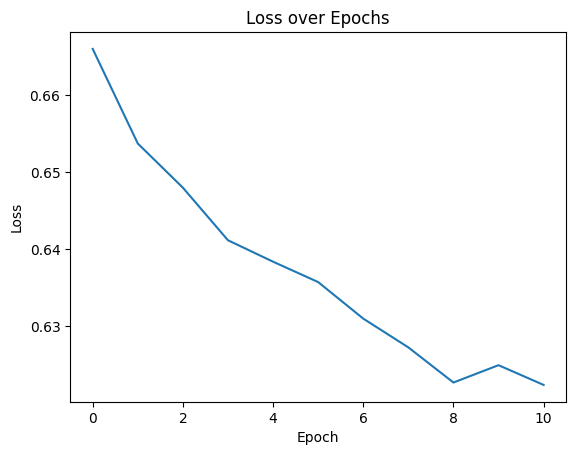

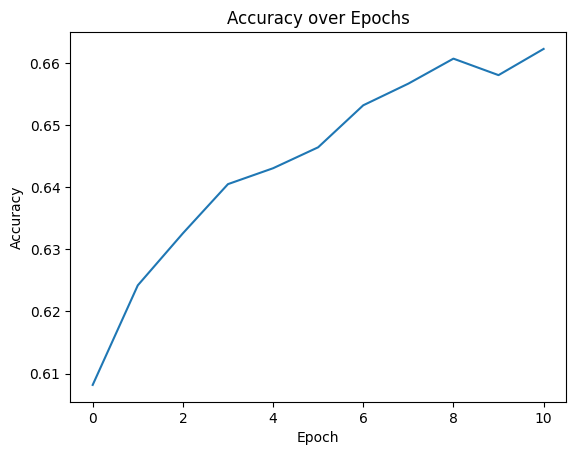

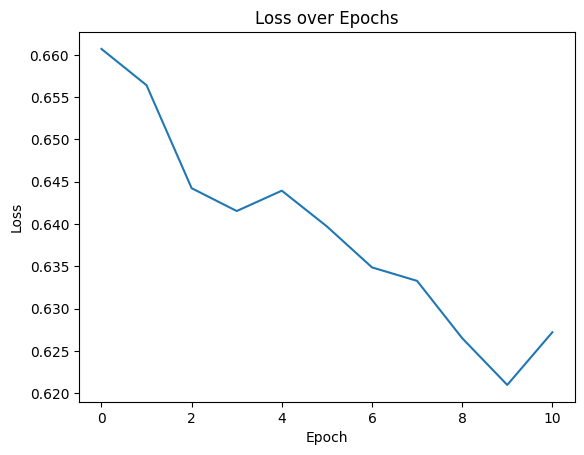

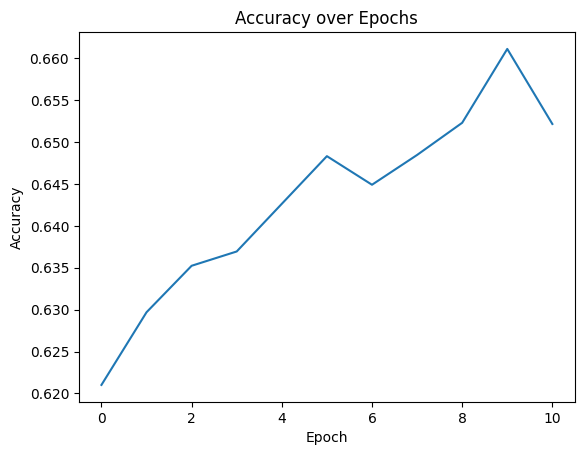

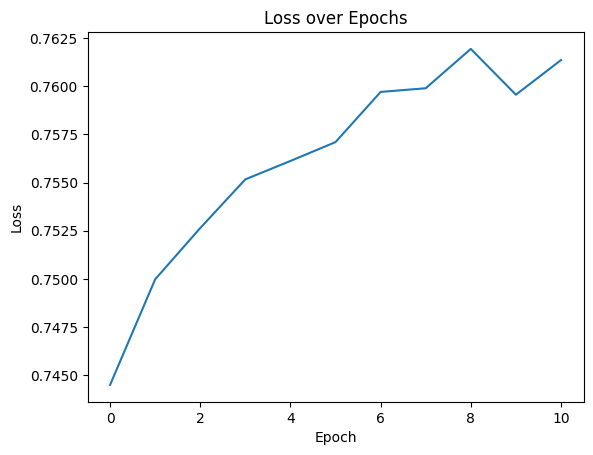

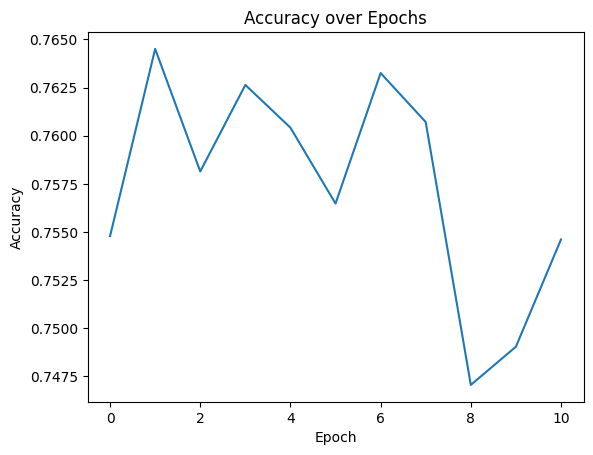

In [56]:
loss_hist, acc_hist , loss_val_hist , \
acc_val_hist, loss_test, acc_test ,\
(f1_hist, f1_val_hist, f1_test) = tvt_save_acc_loss_f1(model, 
                                                        dataset_name, 
                                                        model_name, 
                                                        emotion_dim, 
                                                        train_loader, 
                                                        val_loader,
                                                        test_loader,  
                                                        optimizer, 
                                                        loss_fn, 
                                                        device, 
                                                        num_epochs=num_epochs,
                                                        is_binary= False,
                                                        num_classes= 2,
                                                        pre_path = '..')


print("Training process is done!")
print(f"Test: LOSS: {loss_test}, ACC: {acc_test}")
print(f"Model parameter count: {get_num_params(model,1)}")


# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
model = TCNet_Fusion(input_size= dataset[0][0].shape\
                    , n_classes= 2, channels= dataset[0][0].shape[1],\
                            sampling_rate= 128).to(device)

In [52]:
model = ATCNet(dataset[0][0].shape, dataset[0][0].shape[1] , n_classes=2, n_windows=8,
                   eegn_F1=24, eegn_D=2, eegn_kernelSize=50, eegn_poolSize=1, eegn_dropout=0.3, num_heads=2,
                   tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, fuse='average',activation='elu').to(device)

In [90]:
model = nn.Sequential(nn.Conv2d(1,32,(1,3)),
                      nn.Conv2d(32,32,(32,1)),
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)),
                      nn.Flatten(),  # Flatten the tensor to a 2D tensor: [batch_size, 32]
                      nn.Linear(32,2),
                      nn.Softmax(dim=1)).to(device)

In [42]:
model = DGCNN(in_channels= 5,
              num_electrodes= 32,
              num_layers= 2,
              hid_channels= 32,
              num_classes= 2).to(device)

In [43]:
# model(x_batch.to(device)).shape

In [44]:
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.7347, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [45]:
from torch.utils.data import random_split

In [46]:
_, mini_train_dataset = random_split(train_dataset, (len(train_dataset)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [47]:
# model = TCNet_Fusion(input_size= dataset[0][0].shape\
#                     , n_classes= 2, channels= dataset[0][0].shape[1],\
#                             sampling_rate= 128).to(device)

# model = ATCNet(dataset[0][0].shape, dataset[0][0].shape[1] , n_classes=2, n_windows=8,
#                    eegn_F1=24, eegn_D=2, eegn_kernelSize=50, eegn_poolSize=1, eegn_dropout=0.3, num_heads=2,
#                    tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, fuse='average',activation='elu').to(device)

model = DGCNN(in_channels= 5,
              num_electrodes= 32,
              num_layers= 2,
              hid_channels= 32,
              num_classes= 2).to(device)

In [48]:
loss_fn = nn.CrossEntropyLoss()

In [49]:
optimizer = optim.SGD(model.parameters(), lr=0.1 , weight_decay=1e-4, momentum=0.9) # 0.1 , 0.01 , 0.001 
# optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0001  0.001

In [50]:
torch.autograd.set_detect_anomaly(True)

In [51]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _,_ = train_one_step_tqdm_withF1(model, mini_train_loader, loss_fn, optimizer,device, epoch, is_binary=False, num_classes=2)

Epoch: 99: 100%|██████████| 25/25 [00:02<00:00,  8.97batch/s, F1=1, accuracy=100, loss=8.69e-5]


## Step 3: select best lr

Train all data for one epoch

In [118]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01 , 0.001 , 0.0001]:
  print(f'LR={lr}')
  
  ###################################################################################
  # Choose model here

  # model = TCNet_Fusion(input_size= dataset[0][0].shape , \
  #                     n_classes= 2, channels= dataset[0][0].shape[1],\
  #                     sampling_rate= 128).to(device)
  
  # model = ATCNet(dataset[0][0].shape, dataset[0][0].shape[1] , n_classes=2, n_windows=8,
  #                   eegn_F1=24, eegn_D=2, eegn_kernelSize=50, eegn_poolSize=1, eegn_dropout=0.3, num_heads=2,
  #                   tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, fuse='average',activation='elu').to(device)

  model = DGCNN(in_channels= 128, # 5 : DE-Feature, 128: Time Feature
              num_electrodes= 14, # 32 , 14
              num_layers= 2,
              hid_channels= 32,
              num_classes= 2).to(device)

              
  ##################################################################################

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _,_ = train_one_step_tqdm_withF1(model, train_loader, loss_fn, optimizer,device, epoch, is_binary=False, num_classes=2)
  print()

LR=0.9


Epoch: 4: 100%|██████████| 120/120 [00:55<00:00,  2.18batch/s, F1=0.757, accuracy=60.9, loss=0.671]



LR=0.5


Epoch: 4: 100%|██████████| 120/120 [00:54<00:00,  2.19batch/s, F1=0.757, accuracy=60.9, loss=0.67]



LR=0.2


Epoch: 4: 100%|██████████| 120/120 [00:46<00:00,  2.56batch/s, F1=0.756, accuracy=61.8, loss=0.656]



LR=0.1


Epoch: 4: 100%|██████████| 120/120 [00:43<00:00,  2.75batch/s, F1=0.753, accuracy=62.6, loss=0.651]



LR=0.01


Epoch: 4: 100%|██████████| 120/120 [00:43<00:00,  2.77batch/s, F1=0.754, accuracy=61, loss=0.663]  



LR=0.001


Epoch: 4: 100%|██████████| 120/120 [00:43<00:00,  2.78batch/s, F1=0.718, accuracy=58.7, loss=0.684]



LR=0.0001


Epoch: 4: 100%|██████████| 120/120 [00:43<00:00,  2.75batch/s, F1=0.646, accuracy=54.2, loss=0.794]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [59]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2 , 0.25]:
  for wd in [1e-4, 1e-5, 0.]:

    # Choose model here
    model = TCNet_Fusion(input_size= dataset[0][0].shape , \
                      n_classes= 2, channels= dataset[0][0].shape[1],\
                      sampling_rate= 128).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd , momentum=0.9)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, _loss, _acc, _f1 = train_one_step_tqdm_withF1(model, train_loader, loss_fn, optimizer,device, epoch, is_binary=False, num_classes=2)


    print()

LR=0.08, WD=0.0001


Epoch: 4: 100%|██████████| 120/120 [00:38<00:00,  3.14batch/s, F1=0.755, accuracy=65.3, loss=0.633]



LR=0.08, WD=1e-05


Epoch: 4: 100%|██████████| 120/120 [00:37<00:00,  3.19batch/s, F1=0.754, accuracy=65.3, loss=0.63] 



LR=0.08, WD=0.0


Epoch: 4: 100%|██████████| 120/120 [00:37<00:00,  3.17batch/s, F1=0.753, accuracy=64.9, loss=0.635]



LR=0.09, WD=0.0001


Epoch: 4: 100%|██████████| 120/120 [00:44<00:00,  2.67batch/s, F1=0.752, accuracy=65, loss=0.632]  



LR=0.09, WD=1e-05


Epoch: 4: 100%|██████████| 120/120 [00:38<00:00,  3.13batch/s, F1=0.751, accuracy=65, loss=0.632]  



LR=0.09, WD=0.0


Epoch: 4: 100%|██████████| 120/120 [00:46<00:00,  2.56batch/s, F1=0.753, accuracy=65.2, loss=0.631]



LR=0.1, WD=0.0001


Epoch: 4: 100%|██████████| 120/120 [00:44<00:00,  2.70batch/s, F1=0.752, accuracy=64.9, loss=0.635]



LR=0.1, WD=1e-05


Epoch: 4: 100%|██████████| 120/120 [00:44<00:00,  2.73batch/s, F1=0.755, accuracy=65.3, loss=0.632]



LR=0.1, WD=0.0


Epoch: 4: 100%|██████████| 120/120 [00:42<00:00,  2.85batch/s, F1=0.751, accuracy=64.7, loss=0.636]



LR=0.15, WD=0.0001


Epoch: 4: 100%|██████████| 120/120 [00:42<00:00,  2.83batch/s, F1=0.752, accuracy=64.9, loss=0.635]



LR=0.15, WD=1e-05


Epoch: 4: 100%|██████████| 120/120 [00:41<00:00,  2.92batch/s, F1=0.754, accuracy=65.3, loss=0.632]



LR=0.15, WD=0.0


Epoch: 4: 100%|██████████| 120/120 [00:38<00:00,  3.10batch/s, F1=0.752, accuracy=65, loss=0.634]  



LR=0.2, WD=0.0001


Epoch: 4: 100%|██████████| 120/120 [00:39<00:00,  3.05batch/s, F1=0.753, accuracy=65.1, loss=0.634]



LR=0.2, WD=1e-05


Epoch: 4: 100%|██████████| 120/120 [00:37<00:00,  3.22batch/s, F1=0.751, accuracy=64.7, loss=0.636]



LR=0.2, WD=0.0


Epoch: 4: 100%|██████████| 120/120 [00:37<00:00,  3.24batch/s, F1=0.752, accuracy=65.1, loss=0.632]



LR=0.25, WD=0.0001


Epoch: 4: 100%|██████████| 120/120 [00:43<00:00,  2.79batch/s, F1=0.752, accuracy=65, loss=0.632]  



LR=0.25, WD=1e-05


Epoch: 4: 100%|██████████| 120/120 [00:44<00:00,  2.67batch/s, F1=0.751, accuracy=65, loss=0.633]  



LR=0.25, WD=0.0


Epoch: 4: 100%|██████████| 120/120 [00:43<00:00,  2.77batch/s, F1=0.751, accuracy=64.9, loss=0.634]

## Step 5: train more epochs

In [119]:
# model = TCNet_Fusion(input_size= dataset[0][0].shape , \
#                     n_classes= 2, channels= dataset[0][0].shape[1],\
#                     sampling_rate= 128).to(device)

# model = ATCNet(dataset[0][0].shape, dataset[0][0].shape[1] , n_classes=2, n_windows=8,
#                 eegn_F1=24, eegn_D=2, eegn_kernelSize=50, eegn_poolSize=1, eegn_dropout=0.3, num_heads=2,
#                 tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, fuse='average',activation='elu').to(device)

model = DGCNN(in_channels= 128, # 5 : DE-Feature, 128: Time Feature
              num_electrodes= 14, # 32 , 14
              num_layers= 2,
              hid_channels= 32,
              num_classes= 2).to(device)

In [120]:
lr = 0.1 # 0.2 -> 0.02
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [121]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

f1_train_hist = []
f1_valid_hist = [] 

best_loss_valid = torch.inf
epoch_counter = 0

In [122]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train , f1_train = train_one_step_tqdm_withF1(model, train_loader, loss_fn, optimizer,device, epoch, is_binary=False, num_classes=2)

  # Validation
  loss_valid, acc_valid , f1_valid = validation_with_tqdm_withF1(model, val_loader, loss_fn, device=device, is_binary=False, num_classes=2)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  f1_train_hist.append(f1_train)
  f1_valid_hist.append(f1_valid)

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}, F1= {f1_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, 'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.00batch/s, F1=0.755, accuracy=60.8, loss=0.667]


Valid: Loss = 0.6672, Acc = 0.6085, F1= 0.7555
Model Saved!



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.07batch/s, F1=0.757, accuracy=61, loss=0.666]  


Valid: Loss = 0.666, Acc = 0.6102, F1= 0.7565
Model Saved!



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.01batch/s, F1=0.756, accuracy=61.3, loss=0.664]


Valid: Loss = 0.6641, Acc = 0.6126, F1= 0.7563
Model Saved!



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.07batch/s, F1=0.753, accuracy=61.2, loss=0.665]


Valid: Loss = 0.6652, Acc = 0.6121, F1= 0.7527



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.07batch/s, F1=0.752, accuracy=61.1, loss=0.667]


Valid: Loss = 0.6665, Acc = 0.6109, F1= 0.7515



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.07batch/s, F1=0.739, accuracy=60.7, loss=0.665]


Valid: Loss = 0.6648, Acc = 0.6072, F1= 0.7385



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.09batch/s, F1=0.734, accuracy=60.7, loss=0.669]


Valid: Loss = 0.6691, Acc = 0.6067, F1= 0.7338



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.08batch/s, F1=0.722, accuracy=60.4, loss=0.67] 


Valid: Loss = 0.6701, Acc = 0.6038, F1= 0.7221



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.10batch/s, F1=0.736, accuracy=60.8, loss=0.673]


Valid: Loss = 0.6727, Acc = 0.6081, F1= 0.7358



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.09batch/s, F1=0.725, accuracy=60.2, loss=0.683]


Valid: Loss = 0.683, Acc = 0.6021, F1= 0.7248



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.05batch/s, F1=0.721, accuracy=60.3, loss=0.685]


Valid: Loss = 0.685, Acc = 0.6034, F1= 0.7207



Validation - : 100%|██████████| 14/14 [00:05<00:00,  2.69batch/s, F1=0.69, accuracy=58.6, loss=0.689] 


Valid: Loss = 0.6894, Acc = 0.5859, F1= 0.6899



Validation - : 100%|██████████| 14/14 [00:05<00:00,  2.60batch/s, F1=0.69, accuracy=58.7, loss=0.692] 


Valid: Loss = 0.6919, Acc = 0.587, F1= 0.6897



Validation - : 100%|██████████| 14/14 [00:04<00:00,  2.85batch/s, F1=0.709, accuracy=59.8, loss=0.701]


Valid: Loss = 0.7011, Acc = 0.5978, F1= 0.7086



Validation - : 100%|██████████| 14/14 [00:04<00:00,  2.90batch/s, F1=0.689, accuracy=58.9, loss=0.711]


Valid: Loss = 0.7105, Acc = 0.589, F1= 0.6887



Validation - : 100%|██████████| 14/14 [00:04<00:00,  2.87batch/s, F1=0.724, accuracy=60.5, loss=0.705]


Valid: Loss = 0.7046, Acc = 0.6047, F1= 0.7242



Validation - : 100%|██████████| 14/14 [00:04<00:00,  2.89batch/s, F1=0.69, accuracy=58.7, loss=0.742]


Valid: Loss = 0.7417, Acc = 0.5866, F1= 0.6903



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.09batch/s, F1=0.694, accuracy=59.2, loss=0.744]


Valid: Loss = 0.7444, Acc = 0.5923, F1= 0.6941



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.08batch/s, F1=0.685, accuracy=59, loss=0.749]  


Valid: Loss = 0.749, Acc = 0.5902, F1= 0.6849



Validation - : 100%|██████████| 14/14 [00:04<00:00,  3.06batch/s, F1=0.684, accuracy=58.6, loss=0.745]

Valid: Loss = 0.7455, Acc = 0.5863, F1= 0.6845



# Step 6: plots

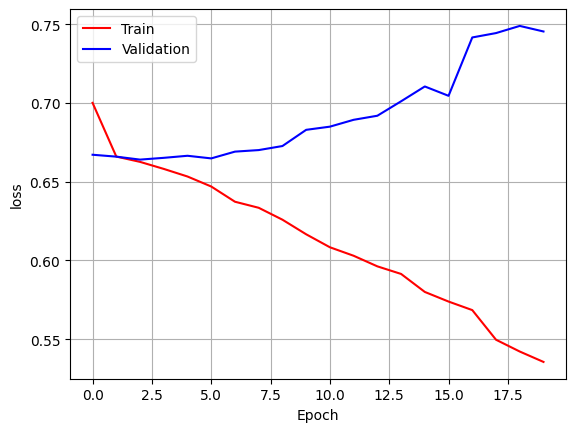

In [123]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

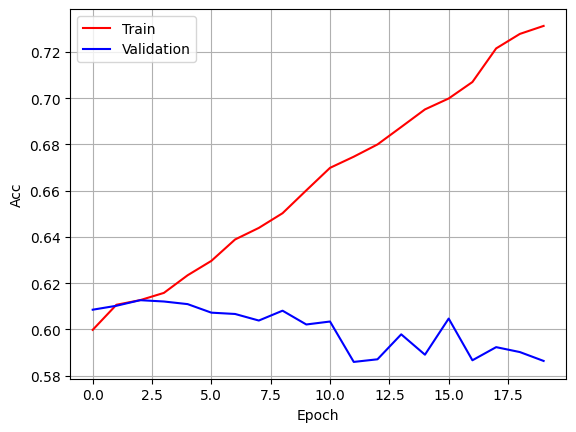

In [124]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()